## SCSS-Net evaluation
In this notebook, we provide code to predict SCSS-Net coronal holes or active regions on test dataset and evaluate it's metrics

In [1]:
import sys, os
sys.path.append('../src/')

In [3]:
import glob
import numpy as np
from datetime import datetime
from PIL import Image
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
import tensorflow
from keras.callbacks import ModelCheckpoint

In [3]:
from model_scss_net import scss_net
from metrics import dice_np, iou_np, dice, iou
from utils import plot_imgs, plot_metrics, plot_top

In [5]:
# define hyperparameters needed for training
IMG_SIZE = 256  # resize imgs to 256x256
BATCH_SIZE = 20 # set batch size
SEED = 42       # set seed for reproducibility
EPOCHS = 100    # Set number of epochs

# specify model filename, you should rewrite MODEL_NAME as yours preferrings
MODEL_NAME = "model_filename"
model_filename = f"{MODEL_NAME}.h5"  

In [6]:
# getting test dataset, 195A (for CH) or 171A (for AR)
imgs_test = glob.glob("../data/train_test_data/AR_test_imgs/*.png")
masks_test = glob.glob("../data/train_test_data/AR_test_masks/*.png")

print(f"Imgs number = {len(imgs_test)}\nMasks number = {len(masks_test)}")

imgs_test_list = []
masks_test_list = []
for image, mask in zip(imgs_test, masks_test):
    imgs_test_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
    masks_test_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))


Imgs number = 656
Masks number = 656


In [7]:
# Normalization from (0; 255) to (0; 1)
x_test = np.asarray(imgs_test_list, dtype=np.float32)/255
y_test = np.asarray(masks_test_list, dtype=np.float32)/255

# Reshape to (n_imgs, height, width, channels)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1)

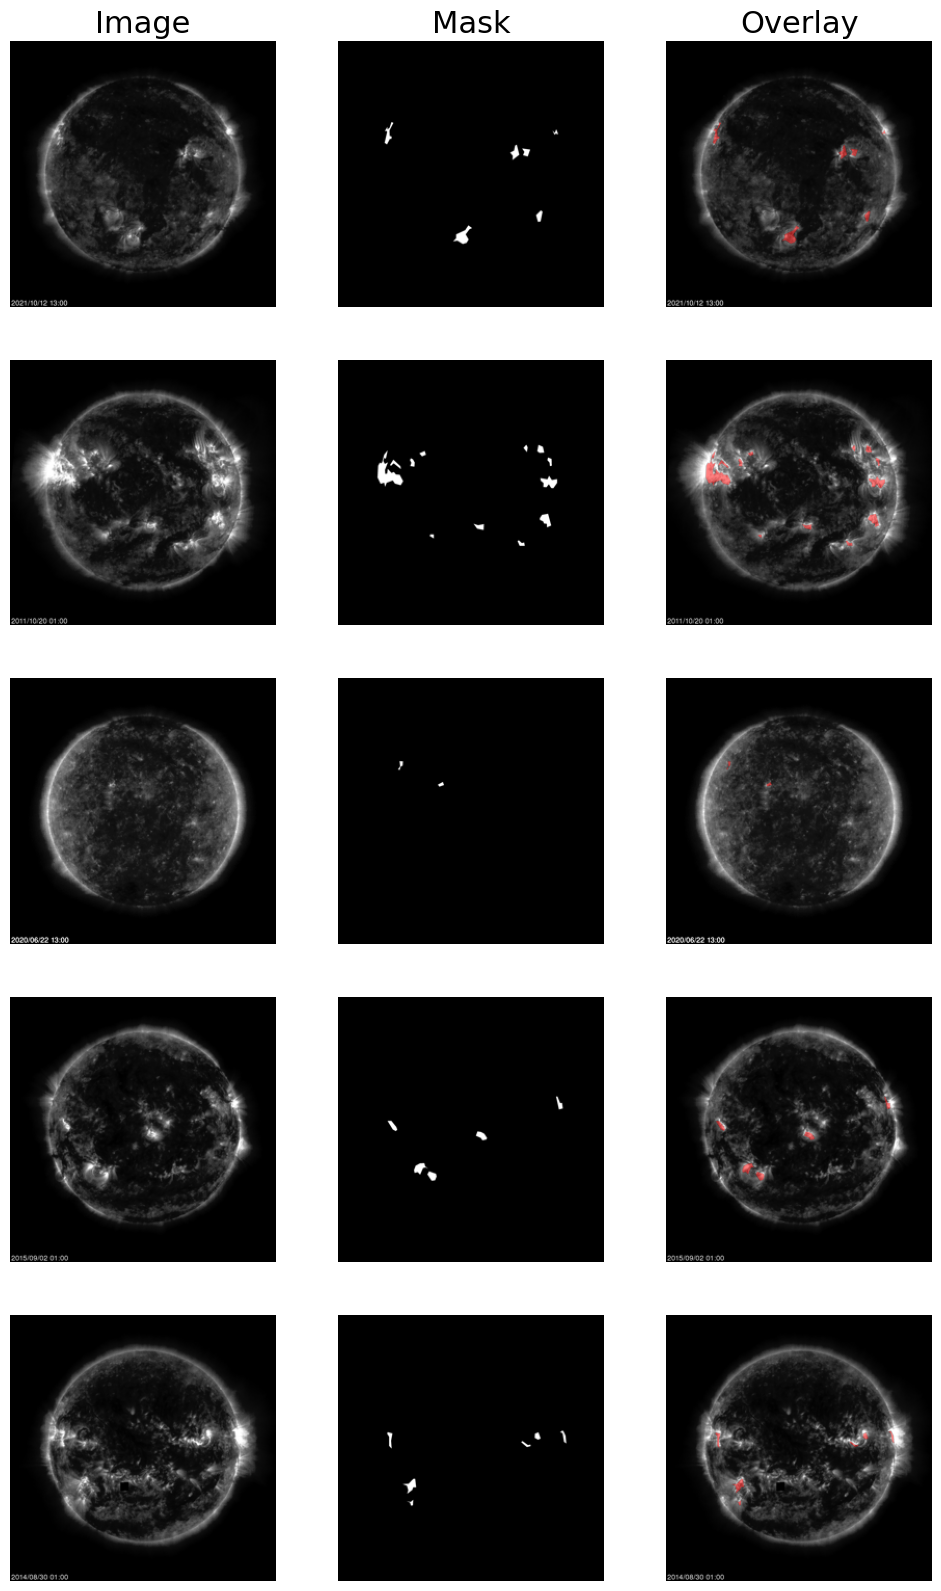

In [8]:
# show images with coresponding mask
plot_imgs(imgs=x_test, masks=y_test, n_imgs=5).show()

In [9]:
# input shape should be (256, 256, 1)
input_shape = x_test[0].shape
print(f"Input shape: {input_shape}\n")

Input shape: (256, 256, 1)



In [10]:
# Load model architecture with optimal parameteres
model = scss_net( 
    input_shape,
    filters=32,       
    layers=4,
    batch_norm=True,
    drop_prob=0.5)

# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  
    metrics=[iou, dice])

In [11]:
# load weights
model.load_weights("ar_model.h5")

## PREDICT

21/21 [==============================] - 79s 4s/step


<function matplotlib.pyplot.show(close=None, block=None)>

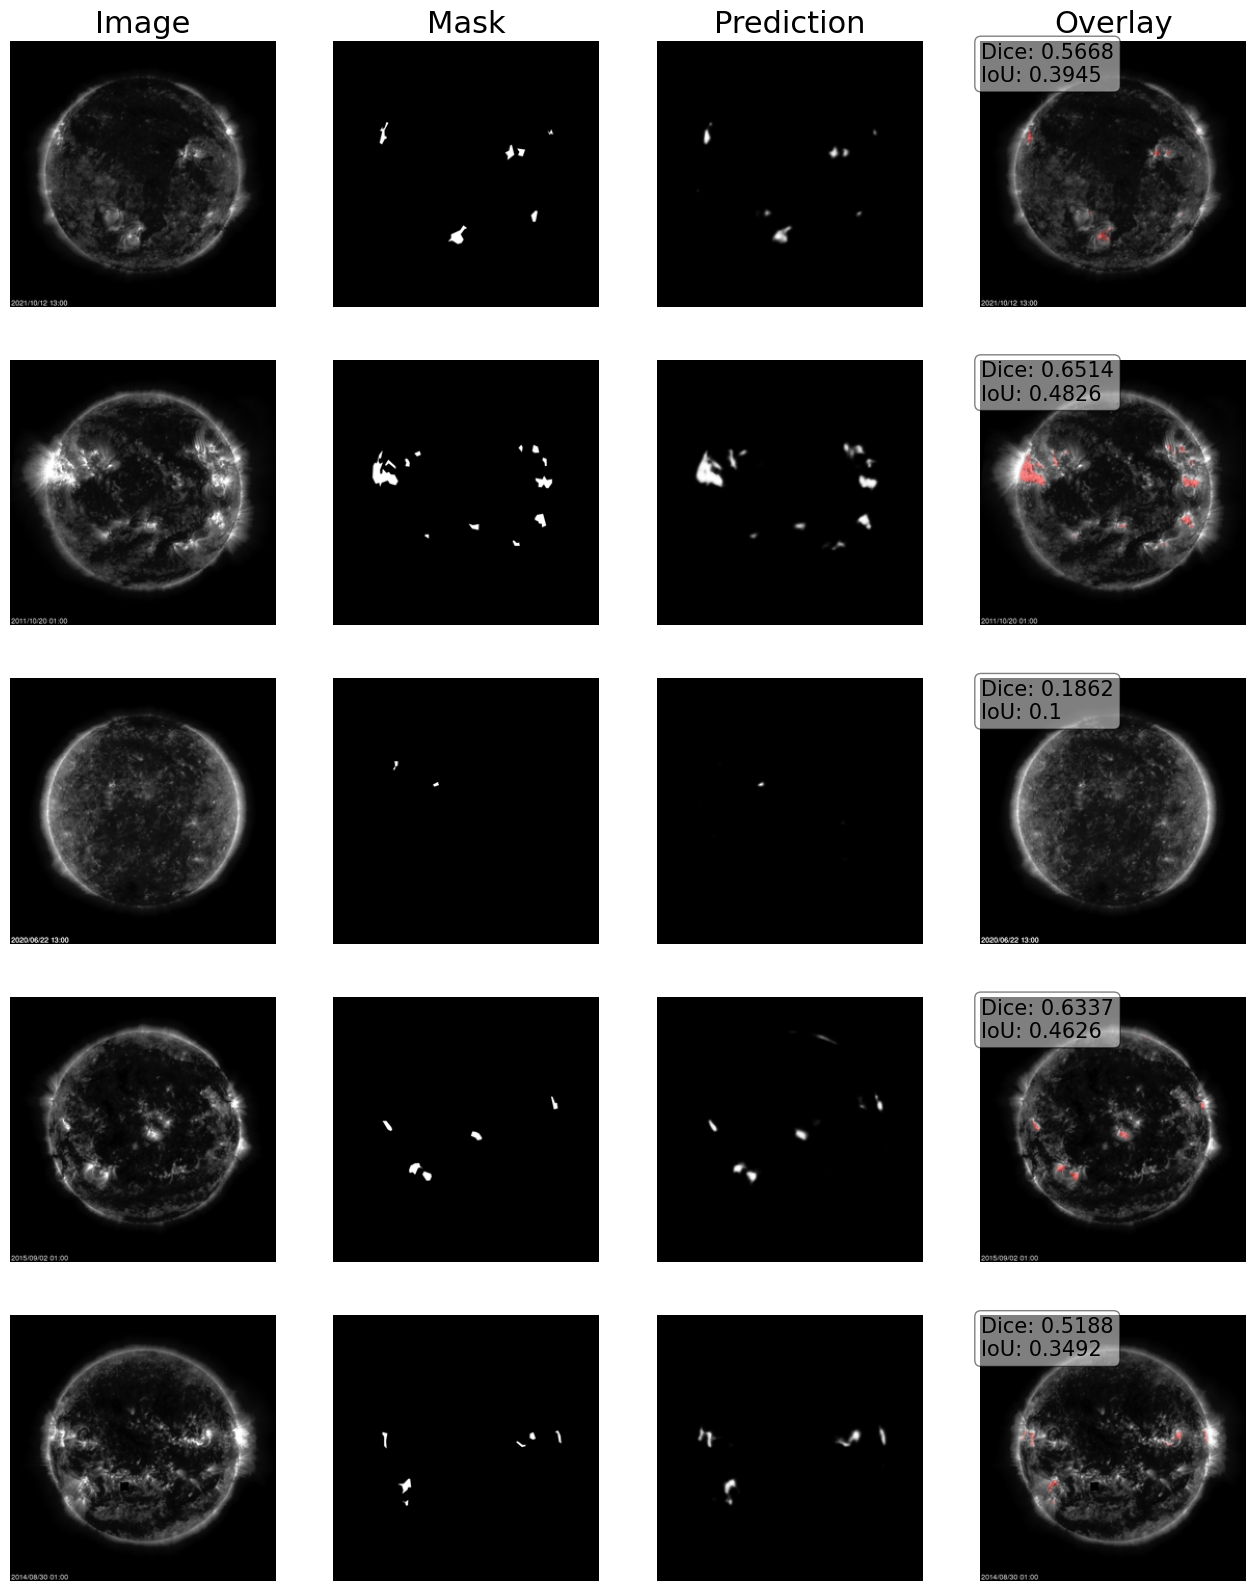

In [15]:
y_pred = model.predict(x_test)  
plot_imgs(imgs=x_test, masks=y_test, predictions=y_pred, n_imgs=5).show

## METRICS

In [16]:
dice = np.round(dice_np(y_test, y_pred), 4)
iou_test = np.round(iou_np(y_test, y_pred), 4)

In [1]:
print(f"Test:\nDice: {dice} |\n IoU: {iou_test} |\n")

## GRAPH FOR TEST SET

In [18]:
dates = []
for name in glob.glob("../data/train_test_data/AR_test_imgs/*.png"):
    name_clean = name[-29:]
    tostrip = name_clean[0:8]
    date = datetime.strptime(tostrip, '%Y%m%d')
    dates.append(date)

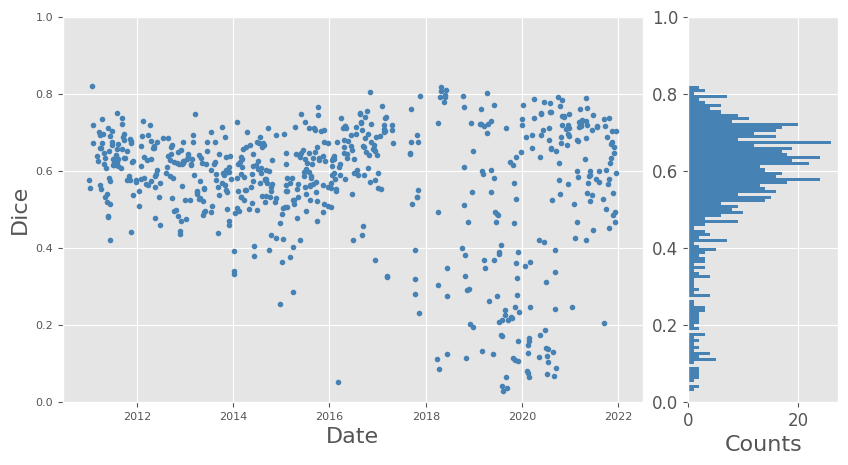



The Dice score is higher than 0.8 for 0.91% of images in test set.


In [19]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

dice = [dice_np(y_test, y_pred) for y_test, y_pred in zip(y_test, y_pred)]

plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(20, 20)
ax_scatter = fig.add_subplot(gs[0:20, 0:15])
ax_hist_x = fig.add_subplot(gs[0:20, 16:20])
ax_scatter.set_xlabel("Date", fontsize=16)
ax_scatter.set_ylabel("Dice", fontsize=16)
ax_scatter.tick_params(axis='both', which='major', labelsize=8)
ax_hist_x.set_xlabel("Counts", fontsize=16)
ax_hist_x.tick_params(axis='both', which='major', labelsize=12)
ax_scatter.set_ylim([0, 1])
ax_hist_x.set_ylim([0, 1])
ax_scatter.plot(dates, dice,'.', label=f'Averaged Dice for SCSS-Net = {dice}', color='steelblue')
ax_hist_x.hist(dice, orientation = 'horizontal', bins=100, color='steelblue')
plt.show()

print("\n")
print(f'The Dice score is higher than 0.8 for {round(len([i for i in dice if i > 0.8])/len(dice)*100,2)}% \
of images in test set.')

## Plotting figs
following outputs for coronal holes and active regions has been saved to ../figures/AR-predicted.png and shown in markdown cell bellow

In [2]:
# plot_imgs(imgs=x_test, masks=y_test, predictions=y_pred, n_imgs=20).savefig("AR-predicted.png")

<img src="../figures/AR-predicted.png"  width="1800" height="8000"> 